<a href="https://colab.research.google.com/github/rubanzasilva/flood_prediction/blob/dev/s04e05_fastai_exp1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#hide
!pip install catboost
!pip install fastkaggle
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 9.9 MB/s eta 0:00:00


In [5]:
#hide
#! [ -e /content ]

#hide
#This imports and sets up everything you will need for this notebook
#
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

#from fastbook import *
#!pip install ucimlrepo
#from ucimlrepo import fetch_ucirepo

from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random

from fastai.imports import *
np.set_printoptions(linewidth=130)


from pathlib import Path
import os


from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score
#from sklearn.metrics import root_mean_squared_error

import xgboost as xgb
from xgboost import plot_importance

import lightgbm as lgb

from catboost import CatBoostClassifier,CatBoostRegressor,Pool, metrics, cv

from ipywidgets import interact


matplotlib.rc('image', cmap='Greys')

from fastkaggle import setup_comp
import optuna

In [16]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rubanzasilva","key":"3c109650146efc9c92fc9e8bfe70d487"}'}

In [21]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

#chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [22]:
comp = 'playground-series-s4e5'

path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

100%|██████████| 28.0M/28.0M [00:01<00:00, 23.6MB/s]


In [23]:
!ls

kaggle.json  playground-series-s4e5  playground-series-s4e5.zip  sample_data


In [24]:
#set_seed(42)

In [25]:
path = Path('playground-series-s4e5/')
path

Path('playground-series-s4e5')

In [26]:
train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv',index_col='id')

In [ ]:
train_df

In [39]:
train_df.shape,test_df.shape

((1117957, 21), (745305, 20))

In [27]:
train_df.columns

Index(['MonsoonIntensity', 'TopographyDrainage', 'RiverManagement',
       'Deforestation', 'Urbanization', 'ClimateChange', 'DamsQuality',
       'Siltation', 'AgriculturalPractices', 'Encroachments',
       'IneffectiveDisasterPreparedness', 'DrainageSystems',
       'CoastalVulnerability', 'Landslides', 'Watersheds',
       'DeterioratingInfrastructure', 'PopulationScore', 'WetlandLoss',
       'InadequatePlanning', 'PoliticalFactors', 'FloodProbability'],
      dtype='object')

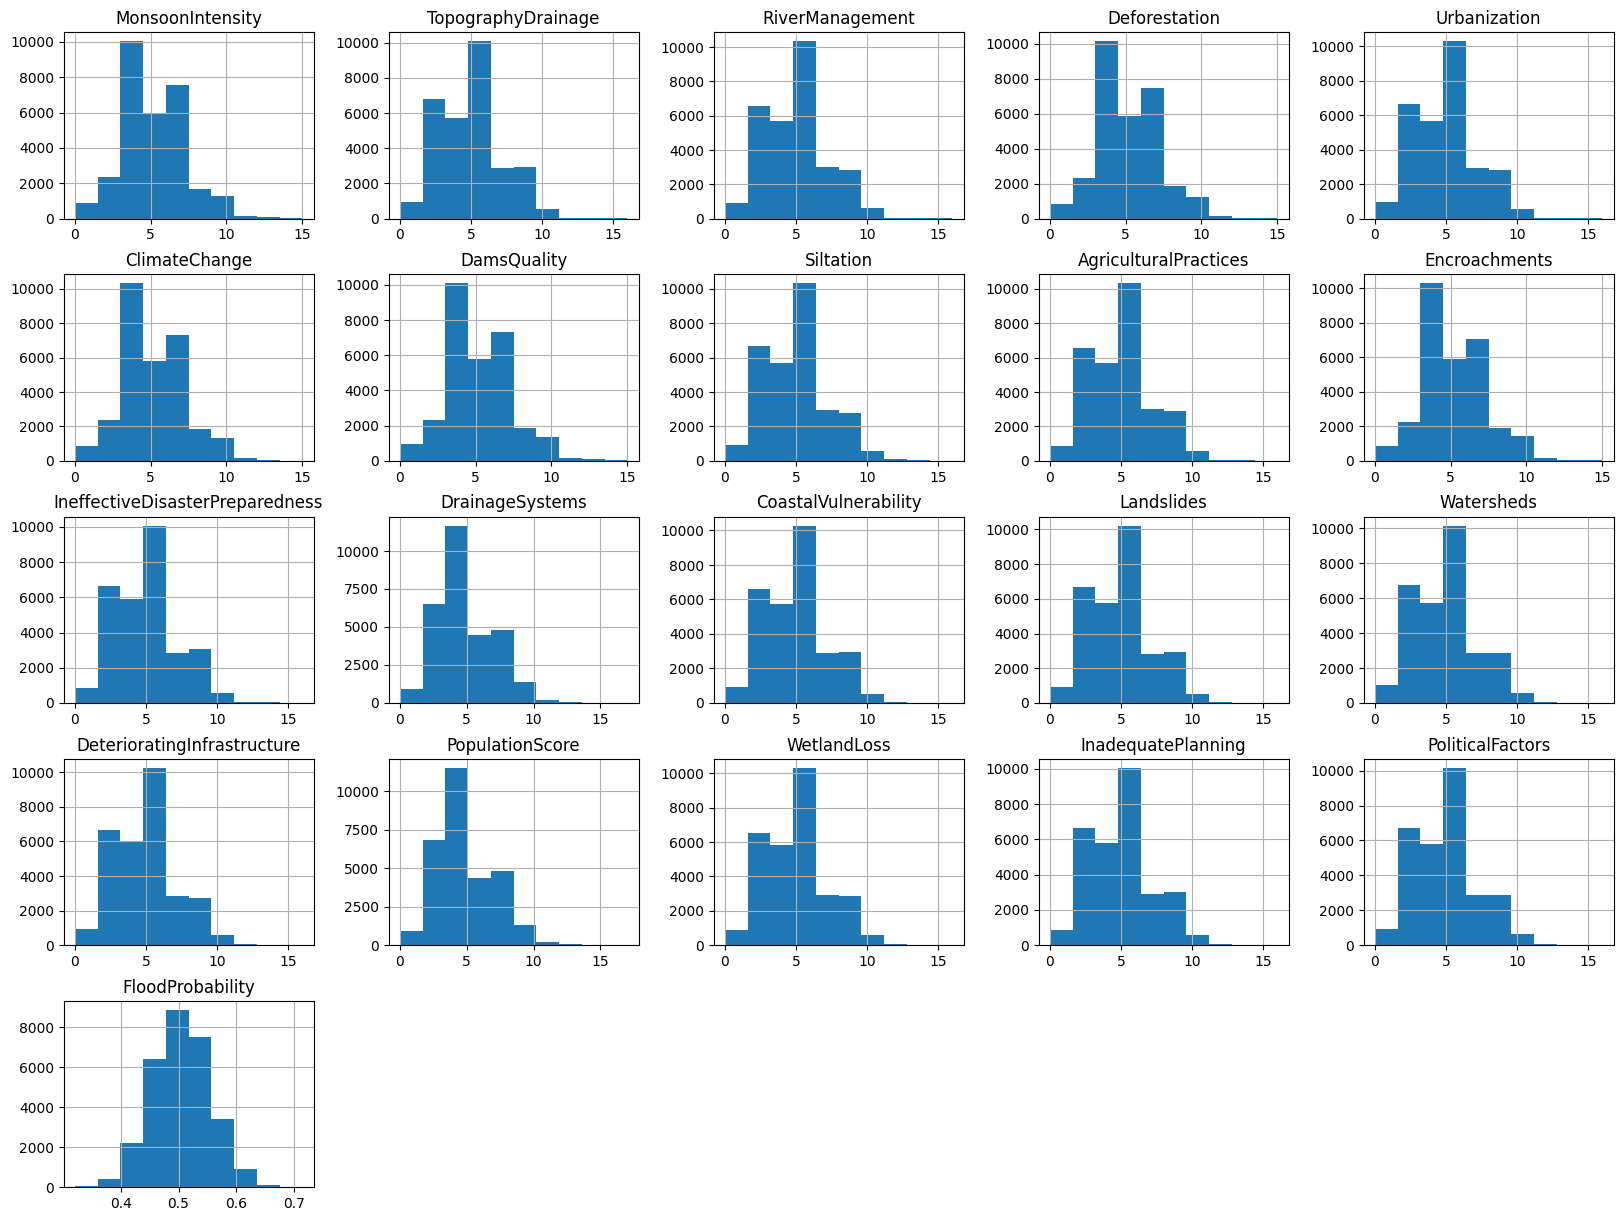

In [42]:
train_subset.hist(figsize=(20,15));

Using Subset

In [40]:
train_subset = train_df.iloc[:30000]
test_subset = test_df.iloc[:30000]

In [43]:
cont_names,cat_names = cont_cat_split(train_subset, dep_var='FloodProbability')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_subset))
to = TabularPandas(train_subset, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='FloodProbability',
                   y_block=RegressionBlock(),
                   splits=splits)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_subset)

SuggestedLRs(slide=0.013182567432522774, valley=0.0010000000474974513)

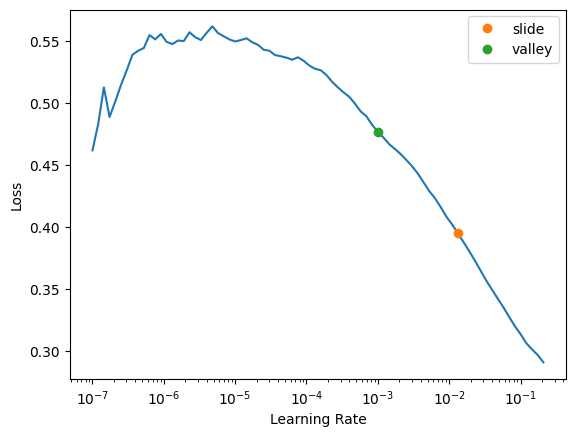

In [44]:
learn = tabular_learner(dls, metrics=R2Score())
learn.lr_find(suggest_funcs=(slide,valley))

In [ ]:
learn.fit_one_cycle(25,0.008)

In [46]:
#learn.fit_one_cycle(5,0.008)
dl = learn.dls.test_dl(test_df)
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)


In [47]:
r2_score(y_test,nn_preds_x)

0.740747148871282

Using random subset

Using a random subset results in better and faster training

In [49]:
train_subset = train_df.sample(n=50000,replace=False)
test_subset = test_df.sample(n=30000,replace=False)

In [50]:
cont_names,cat_names = cont_cat_split(train_subset, dep_var='FloodProbability')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_subset))
to = TabularPandas(train_subset, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='FloodProbability',
                   y_block=RegressionBlock(),
                   splits=splits)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_subset)

SuggestedLRs(slide=0.010964781977236271, valley=0.0020892962347716093)

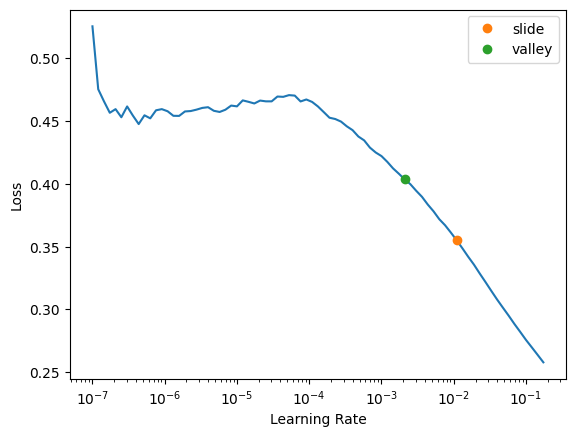

In [51]:
learn = tabular_learner(dls, metrics=R2Score())
learn.lr_find(suggest_funcs=(slide,valley))

In [52]:
learn.fit_one_cycle(50,0.008)
dl = learn.dls.test_dl(test_df)
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)

epoch,train_loss,valid_loss,r2_score,time
0,0.005536,0.004564,-0.765969,00:10
1,0.000927,0.000866,0.665070,00:12
2,0.000750,0.000584,0.774056,00:10
3,0.000685,0.000801,0.690059,00:10
4,0.000745,0.000673,0.739750,00:10
5,0.000761,0.000828,0.679690,00:11
6,0.000886,0.000686,0.734591,00:10
7,0.000793,0.000876,0.661087,00:10
8,0.000748,0.000661,0.744283,00:10
9,0.000769,0.001085,0.580356,00:10


In [53]:
r2_score(y_test,nn_preds_x)

0.7876894977427987

In [54]:
rf = RandomForestRegressor(100, min_samples_leaf=5)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

r2_score(y_test,rf_preds_x)

0.5687041412636994

In [55]:
def objective_rf(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 200, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 32),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10)
    }

    rf_model = RandomForestRegressor(**params)
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict(X_test)
    r2score = r2_score(y_test, rf_predictions)
    return r2score

study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=100)
print(study_rf.best_params)

[I 2024-05-05 08:03:24,654] A new study created in memory with name: no-name-7f83fee9-1876-4ad6-8ed4-142b3201dad5
[I 2024-05-05 08:04:04,047] Trial 0 finished with value: 0.5343833214232556 and parameters: {'n_estimators': 193, 'max_depth': 14, 'min_samples_split': 8, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.5343833214232556.
[I 2024-05-05 08:04:21,932] Trial 1 finished with value: 0.581670600992376 and parameters: {'n_estimators': 68, 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.5343833214232556.
[I 2024-05-05 08:04:27,766] Trial 2 finished with value: 0.5617018689911641 and parameters: {'n_estimators': 20, 'max_depth': 30, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.5343833214232556.
[I 2024-05-05 08:04:35,291] Trial 3 finished with value: 0.5667081070655668 and parameters: {'n_estimators': 34, 'max_depth': 22, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 0 with value: 

{'n_estimators': 26, 'max_depth': 2, 'min_samples_split': 5, 'min_samples_leaf': 1}


In [56]:
rf = RandomForestRegressor(100, min_samples_leaf=5,max_depth=4,min_samples_split=5)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

r2_score(y_test,rf_preds_x)

0.1798761514937982

In [62]:
rf = RandomForestRegressor(26, min_samples_leaf=1,max_depth=2,min_samples_split=5)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

r2_score(y_test,rf_preds_x)

0.08417426348957979

In [60]:
rf = RandomForestRegressor(26, min_samples_leaf=1)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

r2_score(y_test,rf_preds_x)

0.571364082610883

Using Full Dataset

In [28]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='FloodProbability')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='FloodProbability',
                   y_block=RegressionBlock(),
                   splits=splits)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_df)

In [ ]:
learn = tabular_learner(dls, metrics=R2Score())
learn.lr_find(suggest_funcs=(slide,valley))

In [14]:
learn.fit_one_cycle(10,0.008)

epoch,train_loss,valid_loss,r2_score,time
0,0.000582,0.000500,0.808133,03:15
1,0.000510,0.000433,0.833783,03:20
2,0.000473,0.000409,0.843261,03:26
3,0.000470,0.000416,0.840537,03:59
4,0.000491,0.000436,0.832748,03:15
5,0.000467,0.000417,0.840253,03:17
6,0.000438,0.000389,0.850855,03:13
7,0.000408,0.000374,0.856524,03:10
8,0.000387,0.000367,0.859144,03:12
9,0.000397,0.000364,0.860485,03:10


In [15]:
#learn.fit_one_cycle(5,0.008)
dl = learn.dls.test_dl(test_df)
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)

#target_preds = nn_preds[0]

#test_df['Rings'] = target_preds
#test_df.to_csv('submission.csv', columns=['Rings'], index=True)

#submission = pd.read_csv('submission.csv')
#submission.head()


In [16]:
r2_score(y_test,nn_preds_x)

0.8604848131155046

# Random Forest Baseline

In [18]:
rf = RandomForestRegressor(100, min_samples_leaf=5)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

r2_score(y_test,rf_preds_x)

0.6367682362866423

In [3]:
r2_score(y_test,rf_preds_x)

NameError: name 'y_test' is not defined

In [29]:
def objective_rf(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 200, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 32),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10)
    }

    rf_model = RandomForestRegressor(**params)
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict(X_test)
    r2score = r2_score(y_test, rf_predictions)
    return r2score

study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=100)
print(study_rf.best_params)

[I 2024-05-05 07:00:11,753] A new study created in memory with name: no-name-41b90ede-fc0d-4484-a8a9-aedcaa51855c
[I 2024-05-05 07:13:55,764] Trial 0 finished with value: 0.6296607961240914 and parameters: {'n_estimators': 94, 'max_depth': 23, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.6296607961240914.
[W 2024-05-05 07:15:27,692] Trial 1 failed with parameters: {'n_estimators': 36, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 10} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-29-c4e35a659cba>", line 10, in objective_rf
    rf_model.fit(X_train, y_train)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 473, in fit
    trees = Parallel(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py

KeyboardInterrupt: 

In [ ]:
mse = mean_absolute_error(y_test, nn_preds_x)
rmse = np.sqrt(mse)
rmse

0.122799814

In [ ]:
nn_preds_x.shape,nn_preds_y.shape

(torch.Size([223591, 1]), torch.Size([745305]))

In [ ]:
nn_preds[0].shape

torch.Size([745305, 1])

In [ ]:
#target_preds = nn_preds[0]

#test_df['FloodProbability'] = target_preds
#test_df.to_csv('submission.csv', columns=['FloodProbability'], index=True)

#submission = pd.read_csv('submission.csv')
#submission.head()

,id,Rings
0,1117957,0.572112
1,1117958,0.456245
2,1117959,0.454844
3,1117960,0.470216
4,1117961,0.470411


In [ ]:
!ls

 catboost_info	    kaggle.json   playground-series-s4e5       sample_data
'kaggle (1).json'   models	  playground-series-s4e5.zip   submission.csv


In [ ]:
#!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "nn_preds"

100% 13.2M/13.2M [00:01<00:00, 9.20MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset

In [ ]:
!rm submission.csv

In [ ]:
!ls

 catboost_info	    kaggle.json   playground-series-s4e5       sample_data
'kaggle (1).json'   models	  playground-series-s4e5.zip


In [ ]:
def objective_catboost(trial):
    params = {
        "iterations": 200,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "random_strength": trial.suggest_int("random_strength", 1, 10),
    }
    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
    cat_predictions = model.predict(X_test)
    r2score = r2_score(y_test, cat_predictions)
    return r2score

study_catboost = optuna.create_study(direction='minimize')
study_catboost.optimize(objective_catboost, n_trials=100)
print(study_catboost.best_params)

In [ ]:
#with optuna params
cat_model = CatBoostRegressor(iterations=500, depth=7, learning_rate= 0.2222399612038645, random_strength=5)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

#mse = mean_absolute_error(y_test, cat_preds_x)
#rmse = np.sqrt(mse)
#rmse

In [23]:
def objective_xgboost(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    xgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, xgb_predictions)
    return r2score


study_xgboost = optuna.create_study(direction='minimize')
study_xgboost.optimize(objective_xgboost, n_trials=100)
print(study_xgboost.best_params)

[I 2024-05-04 21:38:57,586] A new study created in memory with name: no-name-f58b624c-e886-40be-ba0e-3c7bd861b39b
[I 2024-05-04 21:39:27,451] Trial 0 finished with value: 0.7381575006660547 and parameters: {'n_estimators': 134, 'max_depth': 10, 'learning_rate': 0.03311226879433602, 'subsample': 0.1022415225177117}. Best is trial 0 with value: 0.7381575006660547.
[I 2024-05-04 21:39:37,539] Trial 1 finished with value: 0.45515210980464726 and parameters: {'n_estimators': 133, 'max_depth': 2, 'learning_rate': 0.061446088876858, 'subsample': 0.763050134042984}. Best is trial 1 with value: 0.45515210980464726.
[I 2024-05-04 21:39:54,600] Trial 2 finished with value: 0.35744870304826293 and parameters: {'n_estimators': 114, 'max_depth': 7, 'learning_rate': 0.013524686555747983, 'subsample': 0.7821138362469764}. Best is trial 2 with value: 0.35744870304826293.
[I 2024-05-04 21:40:08,375] Trial 3 finished with value: 0.6317538144673501 and parameters: {'n_estimators': 172, 'max_depth': 4, 'le

{'n_estimators': 148, 'max_depth': 1, 'learning_rate': 0.010075584926403267, 'subsample': 0.6945377090487166}


In [25]:
xgb_model = xgb.XGBRegressor(n_estimators = 187, max_depth=8, learning_rate=0.010075584926403267, subsample= 0.6945377090487166)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

r2_score(y_test,xgb_preds_x)

0.44624773484062163

In [ ]:
import lightgbm as lgb

def objective_lgbm(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    lgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, lgb_predictions)
    return r2score


study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=100)
print(study_lgbm.best_params)

In [ ]:
lgb_model = lgb.LGBMRegressor(num_leaves=28, learning_rate=0.010304173017857115, n_estimators=102)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))

lgb_score = r2_score(y_test,lgb_preds_x)
lgb_score

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = cat_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

In [ ]:
!ls

 catboost_info	    kaggle.json   playground-series-s4e5       sample_data
'kaggle (1).json'   models	  playground-series-s4e5.zip   submission.csv


In [ ]:
mse = mean_absolute_error(y_test,cat_preds_x)
rmse = np.sqrt(mse)
rmse

0.12580042

In [ ]:
!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "cat boost"

100% 13.2M/13.2M [00:01<00:00, 9.79MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset

In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators = 187, max_depth=8, learning_rate=0.046018206875864616, subsample=0.7091172175235119)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

KeyboardInterrupt: 

In [ ]:
r2_score(y_test,xgb_preds_x)

0.7817602531907657

In [ ]:
mse = mean_absolute_error(y_test, xgb_preds_x)
rmse = np.sqrt(mse)
rmse

0.13967574

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = xgb_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

In [ ]:
!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "xgboost"

100% 13.1M/13.1M [00:01<00:00, 9.87MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504491


0.8235475438046409

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = lgb_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

In [ ]:
!rm submission.csv

In [ ]:
!ls

 catboost_info	    kaggle.json   playground-series-s4e5       sample_data
'kaggle (1).json'   models	  playground-series-s4e5.zip


In [ ]:
sub = pd.read_csv('submission.csv')
sub

,id,FloodProbability
0,1117957,0.575180
1,1117958,0.463337
2,1117959,0.450641
3,1117960,0.460754
4,1117961,0.461083
...,...,...
745300,1863257,0.484195
745301,1863258,0.457408
745302,1863259,0.634439
745303,1863260,0.566786


In [ ]:
!ls

 catboost_info	    kaggle.json   playground-series-s4e5       sample_data
'kaggle (1).json'   models	  playground-series-s4e5.zip   submission.csv


In [ ]:
!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "lgb preds"

100% 13.2M/13.2M [00:00<00:00, 17.0MB/s]
Successfully submitted to Regression with a Flood Prediction Dataset

In [ ]:
!ls

In [ ]:
!rm submission.csv

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = rf_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')
sub

,id,FloodProbability,Rings
0,1117957,0.5,0.568910
1,1117958,0.5,0.454981
2,1117959,0.5,0.450971
3,1117960,0.5,0.471085
4,1117961,0.5,0.470031
...,...,...,...
745300,1863257,0.5,0.475079
745301,1863258,0.5,0.446771
745302,1863259,0.5,0.616611
745303,1863260,0.5,0.546384


In [ ]:
!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "rf_preds"

In [ ]:
!ls

In [ ]:
general_preds = (lgb_preds + xgb_preds + cat_preds)

In [ ]:
general_preds

tensor([1.7166, 1.3715, 1.3782,  ..., 1.8436, 1.6442, 1.5364])